!pip install connectivipy

!pip install pyEDFlib

!pip install networkx

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
#import matplotlib.pyplot as plt
import random

In [2]:
import numpy as np
import pyedflib
import pandas as pd
import connectivipy as cp

In [3]:
file_name= 'S038R01.edf'
file_name2= 'S038R02.edf'

In [4]:
def read_data_file(file):
    f = pyedflib.EdfReader(file)
    
    n = f.signals_in_file
    #signal_labels = f.getSignalLabels()
    signal_labels = [name.replace(".","") for name in f.getSignalLabels()]
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    #data=pd.DataFrame(sigbufs).T
    #data.columns=signal_labels
    return signal_labels,sigbufs

In [5]:
labels, data = read_data_file(file_name)
labels2, data2 = read_data_file(file_name2)

1.1 (mandatory) Estimate functional brain connectivity among 64 channels using one of the
MVAR estimators: Partial Directed Coherence (PDC), Direct Transfer Function (DTF). Select
one relevant frequency value. Apply a threshold so that the resulting binary connectivity
matrices have network density equal to 20%. Create a graphical representation of the binary
adjacency matrix.

https://connectivipy.readthedocs.io/en/latest/tutorial.html

In [6]:
len(labels)

64

In [7]:
def estimation_1(data, nrepp):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    dtf_values = dt.conn('dtf')
    dtf_significance = dt.significance(Nrep=nrepp, alpha=0.05)
    return dtf_significance

In [8]:
def estimation_2(data, freq):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    dtf = cp.conn.dtf_fun(ar, vr, fs=10, resolution=100, generalized=False)[freq,:,:]
    return dtf

In [9]:
def estimation_3(data,freq):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    pdc = cp.conn.pdc_fun(ar, vr, fs=10, resolution=100, generalized=False)[freq,:,:]
    return pdc

In [10]:
def find_T_est_1(significance,density): # i think our graph will be directed, 
    #but in case if it is undirected the we need to change formula
    total_num = significance.shape[0]*(significance.shape[1])
    k = significance.shape[0]
    n = int( density*total_num+k)
    T = sorted(significance.flatten())[-n]
    return T

In [11]:
def build_adj(est, T):
    adj = 1*(est>T)
    return adj

In [12]:
def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

In [13]:
def build_graph(adj,labels):
    idx_i, inx_j = np.where(adj==1)
    idx_i, inx_j = list(idx_i), list(inx_j )
    #check_symmetric(adj_matr)
    Edges = [(labels[idx_i[i]],labels[inx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]
    our_graph=nx.DiGraph()
    our_graph.add_nodes_from(labels)
    our_graph.add_edges_from(Edges)
    pos = nx.kamada_kawai_layout(our_graph)
    plt.figure(3,figsize=(9,9)) 
    nx.draw(our_graph,pos,with_labels=True)
    #plt.figure(3,figsize=(16,16)) 
    plt.draw()
    plt.show()
    return our_graph

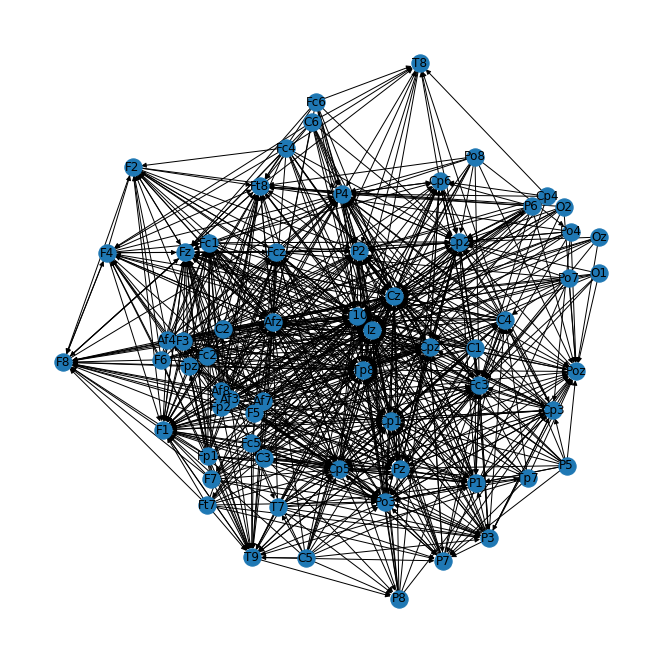

In [14]:
dtf= estimation_2(data,9)
T= find_T_est_1(dtf,0.2)
adjj= build_adj(dtf, T)
gg= build_graph(adjj,labels)

In [15]:
len(gg.edges)/(64*63)

0.20287698412698413

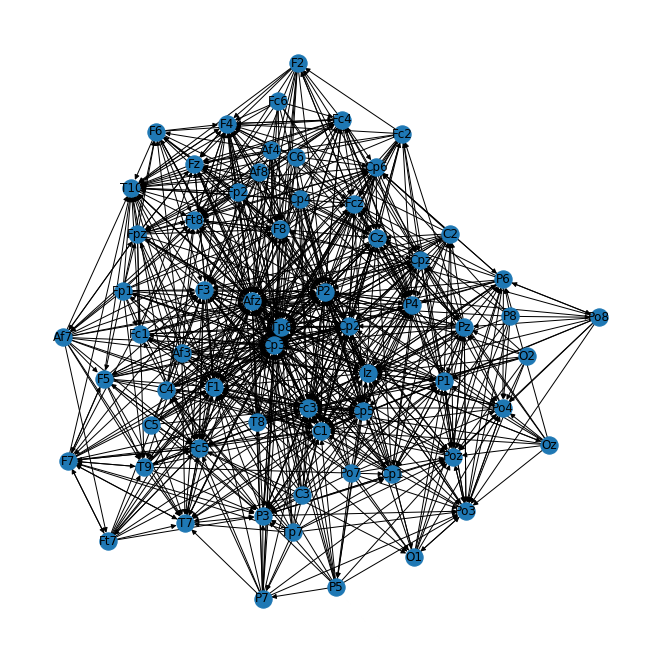

In [16]:
dtf2= estimation_2(data2,9)
T= find_T_est_1(dtf2,0.2)
adjj2= build_adj(dtf2, T)
gg2= build_graph(adjj2,labels2)

In [17]:
len(gg2.edges)/(64*63)

0.20287698412698413

# 1.2
(class ‘A’) Perform task 1.1 using both estimators (PDC and DTF).

False


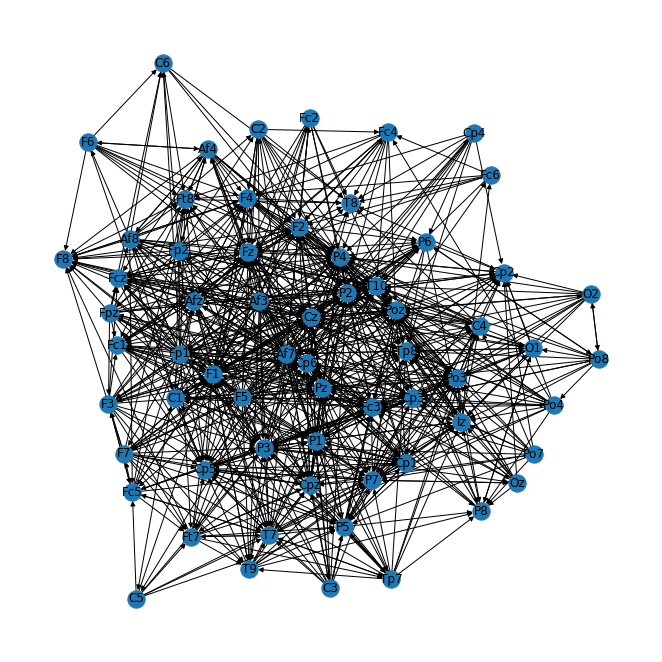

In [16]:
pdc= estimation_3(data,9) # second approach

T= find_T_est_1(pdc,0.2)
adjj= build_adj(pdc, T)
print(check_symmetric(adjj))
gg3= build_graph(adjj,labels)

In [19]:
len(gg3.edges)/(64*63)

0.20287698412698413

False


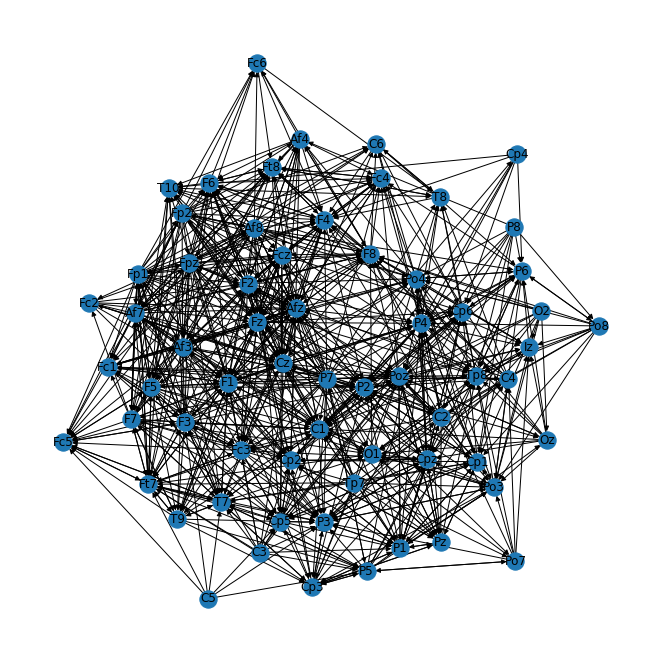

In [20]:
pdc2= estimation_3(data2,9) # second approach

T= find_T_est_1(pdc2,0.2)
adjj3= build_adj(pdc2, T)
print(check_symmetric(adjj3))
gg4= build_graph(adjj3,labels2)

In [21]:
len(gg4.edges)/(64*63)

0.20287698412698413

# 1.4.
(class ‘D’) Considering the subset of 19 channels suggested in Figure 1 and Table 2, estimate
the connectivity using PDC or DTF and apply a statistical validation method (asymptotic
statistics 7 , resampling procedure 8 ,...) to filter out values that are not significantly different
from 0 (PDC(i, j) ≠ 0 with p < 5%)

In [17]:
sub_labels=['Fp1','Fp2','F7','F3','Fz','F4','F8','T7','C3','Cz','C4','T8','P7','P3','Pz','P4','P8','O1',\
            'O2']
idx_labels=[labels.index(sub_labels[i]) for i in range(19)]
sub_data = data[idx_labels,]

In [18]:
sign_19= estimation_1(sub_data, 100) # in this procedure is already specified alpha=0.05

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


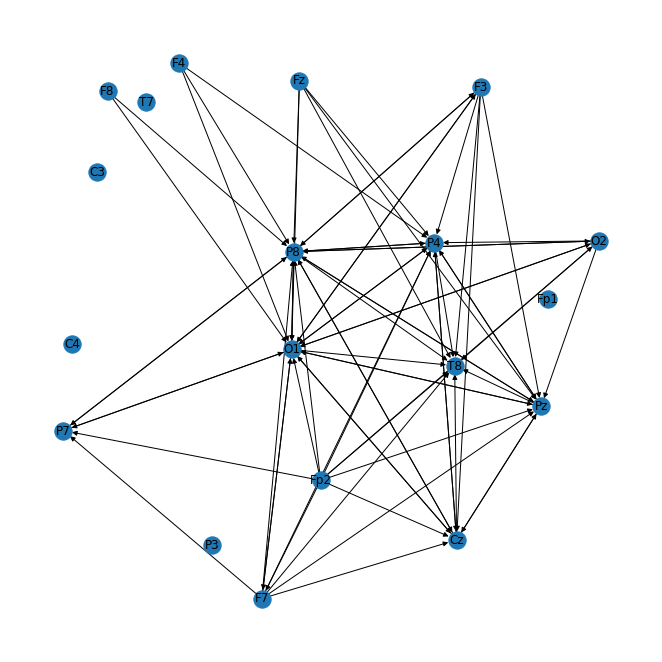

In [25]:
T= find_T_est_1(sign_19,0.2)
adjj19= build_adj(sign_19, T)
gg5= build_graph(adjj19,sub_labels)

In [25]:
len(gg5.edges)/(19*18)

0.20760233918128654

In [26]:
sub_labels=['Fp1','Fp2','F7','F3','Fz','F4','F8','T7','C3','Cz','C4','T8','P7','P3','Pz','P4','P8','O1',\
            'O2']
idx_labels=[labels2.index(sub_labels[i]) for i in range(19)]
sub_data2 = data2[idx_labels,]

In [27]:
sign_19_2= estimation_1(sub_data2, 100) # in this procedure is already specified alpha=0.05

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


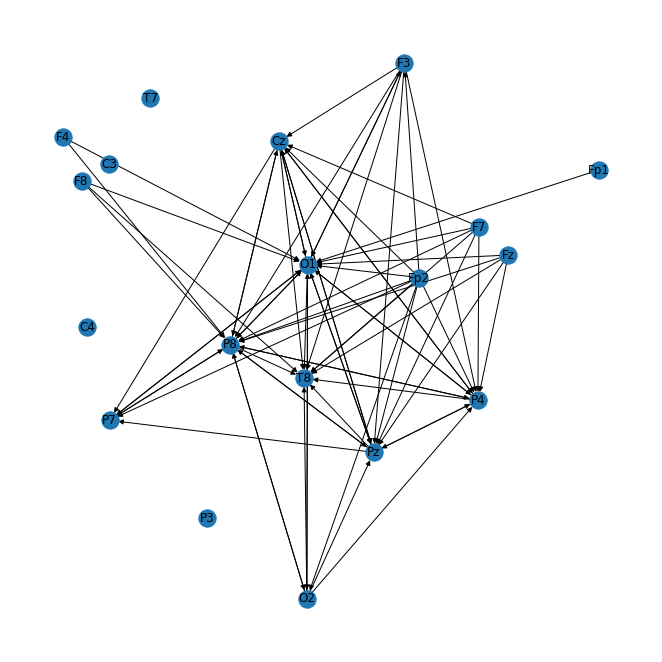

In [28]:
T= find_T_est_1(sign_19,0.2)
adjj19_2= build_adj(sign_19, T)
gg6= build_graph(adjj19_2,sub_labels)

In [29]:
len(gg6.edges)/(19*18)

0.20760233918128654

# 1.5.
(class ‘C’) Make a topographical representation of the networks (see example in Figure 2).
Cartesian coordinates of planar representation of EEG channels are available in Table 3 (see
also
the
file
channel_locations.txt).
(the choice of this task is advised in the case of 19-channel networks and/or density ≤ 5%).

In [128]:
#channel_locations.txt
chanel_locations = pd.read_table('channel_locations.txt', sep=' ', usecols=['label','x','y'])
chanel_locations['label']=chanel_locations['label'].str.replace('.','')

In [20]:
chanel_locations[chanel_locations['label']=='Fc5']['x'].values.item(0)

-0.278155156

In [21]:
def build_graph_1_5(adj,nodes,labels,coord):
    idx_i, inx_j = np.where(adj==1)
    idx_i, inx_j = list(idx_i), list(inx_j )
    #check_symmetric(adj_matr)
    our_graph=nx.DiGraph()
    for i in range(len(labels)):
        our_graph.add_node(labels[i],
                          pos=(coord[coord['label']==labels[i]]['x'].values.item(0),
                              coord[coord['label']==labels[i]]['y'].values.item(0)))
    Edges = [(nodes[idx_i[i]],nodes[inx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]
    
    #our_graph.add_nodes_from(labels)
    our_graph.add_edges_from(Edges)
    pos=nx.get_node_attributes(our_graph,'pos')
    #pos = nx.kamada_kawai_layout(our_graph)
    plt.figure(3,figsize=(9,9)) 
    nx.draw(our_graph,pos,with_labels=True)
    #plt.figure(3,figsize=(16,16)) 
    plt.draw()
    plt.show()
    return our_graph

False


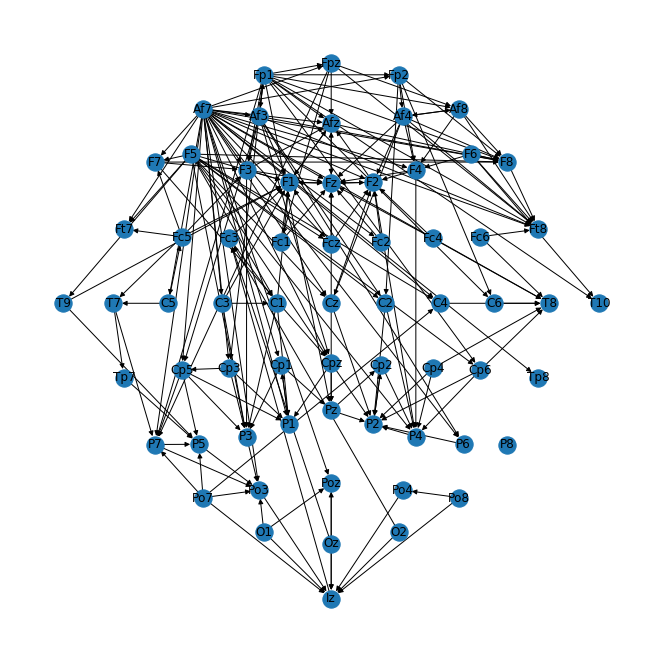

In [22]:
#pdc= estimation_3(data,9) # second approach

T= find_T_est_1(pdc,0.05)
adjj005= build_adj(pdc, T)
print(check_symmetric(adjj005))
gg7= build_graph_1_5(adjj005,labels,labels,chanel_locations)

In [23]:
len(gg7.edges)/(64*63)

0.050347222222222224

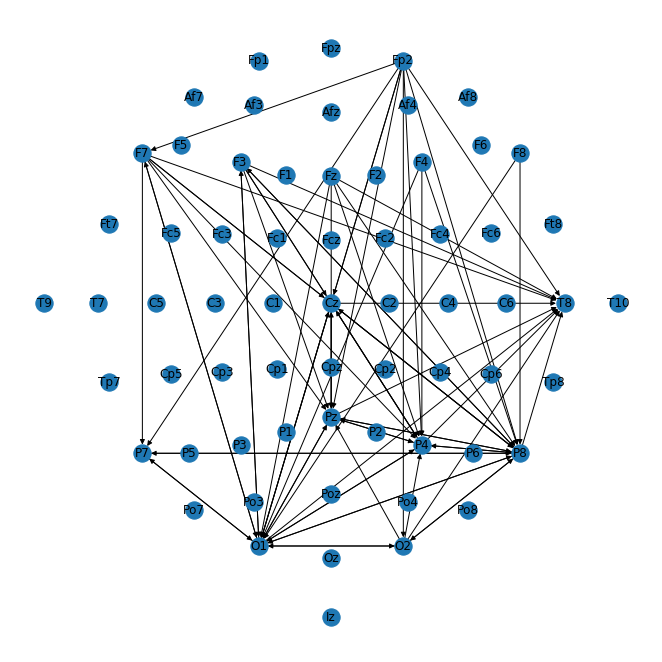

In [27]:
gg8= build_graph_1_5(adjj19,sub_labels,labels,chanel_locations)

In [28]:
len(gg8.edges)/(64*63)

0.017609126984126984

# 2.1
(mandatory) Compute binary global (clustering coefficient, path length) and local (degree,
in/out-degree) graph indices. List the highest 10 channels for local indices.


C_n = e_n/(k_n(k_n-1))
C_n - clustering coeff of node n
e_n - number of edges among neigbors
k_n - number possible edges number

In [15]:
#global clustering coefficient, is avg of CC among all nodes
def avg_CC(graph):
    CC=[]
    all_edg = set()
    for node in graph.nodes:
        #print(node)
        neighbors = (set(graph.successors(node))).union(set(graph.predecessors(node)))
        #print(neighbors)
        e=0
        neighbors.add(node)
        edges = set(graph.in_edges(node))
        edges= edges.union(set(graph.out_edges(node)))
        for ne in neighbors:
            edges= edges.union(set(graph.in_edges(ne)))
            edges = edges.union(set(graph.out_edges(ne)))
            
            #print("edges")
            #print(edges)
        for edg in edges:
            x, y = edg

            if (x in neighbors) and (y in neighbors):
                e=e+1
                    #print(1)
            #all_edg = all_edg.union(edges)
        #print(e)
        k = len(neighbors)*(len(neighbors)-1)
        #print(k)
        CC.append(e/(k))
    return np.sum(CC)/len(CC)

In [16]:
(avg_CC(gg)) # so it is closer to 1, we can say that network can form some clusters

0.4096549614681534

# 3.1.
(mandatory) Perform motifs analysis to investigate the presence of 3-node configurations in
the networks: determine their frequency and statistical significance (motifs, anti-motifs).

In [39]:
#configs = ['A->B->C', 'A->B->C->A','A<-B->C','A->B<-C','A<-B->C->A','A->B<-C->A',\
 #         'A<-B->C<-A','A->B<-C<-A']

In [40]:
gg.nodes

NodeView(('Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz'))

In [41]:
gg.is_directed()

True

In [42]:
gg.in_edges('Fc5')

InEdgeDataView([('C5', 'Fc5')])

In [43]:
gg.out_edges('Fc5')

OutEdgeDataView([('Fc5', 'Fc3'), ('Fc5', 'C4'), ('Fc5', 'Cp5'), ('Fc5', 'Cp1'), ('Fc5', 'Afz'), ('Fc5', 'F3'), ('Fc5', 'F1'), ('Fc5', 'Fz'), ('Fc5', 'Ft7'), ('Fc5', 'T7'), ('Fc5', 'T9'), ('Fc5', 'T10'), ('Fc5', 'Tp8'), ('Fc5', 'P3'), ('Fc5', 'Pz'), ('Fc5', 'P8'), ('Fc5', 'Po3'), ('Fc5', 'Iz')])

In [44]:
set(gg.predecessors('Fc5'))

{'C5'}

In [45]:
set(gg.successors('Fc5'))

{'Afz',
 'C4',
 'Cp1',
 'Cp5',
 'F1',
 'F3',
 'Fc3',
 'Ft7',
 'Fz',
 'Iz',
 'P3',
 'P8',
 'Po3',
 'Pz',
 'T10',
 'T7',
 'T9',
 'Tp8'}

In [145]:
def get_freq(graph):
    #pics=[]
    configs = ['A->B->C', 'A->B->C->A','A->B<-C','A->B<-C->A','A<-B->C', 'A<-B->C->A']
    #'A->B->C' #'A->B->C->A or A->B->C->B' # 'A->B->C->A->C' # A->B->C->A->C->B->A # A->B->C->B->A
    conf1,conf2,conf22,conf222,conf_4,conf_5,conf_6 = set(),set(),set(),set(),set(),set(),set()
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            third_step = set(graph.successors(sec))
            for th in third_step:
                if th!=node:
                    conf1.add(tuple(sorted(set([node,sec,th])) ))
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == sec:
                            fifth = set(graph.successors(fourth))
                            for fi in fifth:
                                if node==fi:
                                    conf_6.add(tuple(sorted(set([node,sec,th,fourth,fi])) ))#(())
                        if fourth == node :
                            conf2.add(tuple(sorted(set([node,sec,th,fourth]))))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:

                                if fif==th:
                                    conf222.add(tuple(sorted(set([node,sec,th,fourth,fif]))))                            
                                    six = set(graph.successors(fif))
                                    for s in six:
                                        conf_4.add(tuple(sorted(set([node,sec,th,fourth,fif,s]))))
                                        if s==sec:
                                            sev = set(graph.successors(s))
                                            for se in sev:
                                                if se==node:
                                                    conf_5.add(tuple(sorted(set([node,sec,th,fourth,fif,s,se]))))
                    if fourth==sec:
                        conf22.add(tuple(sorted(set([node,sec,th,fourth]))))
    poss_confs={configs[0] : [len(conf1)]}
    poss_confs[configs[1]]=[len(conf2)]
    poss_confs['A->B->C->B']=[len(conf22)]
    poss_confs['A->B->C->A->C']=[len(conf222)]
    poss_confs['A->B->C->A->C->B']=[len(conf_4)]
    poss_confs['A->B->C->A->C->B->A']=[len(conf_5)]
    poss_confs['A->B->C->B->A']=[len(conf_6)]
    #pics.extend([conf1.pop(),conf2.pop(),conf22.pop(),conf222.pop(),conf_4.pop(),conf_5.pop()])
        #'A->B<-C' #'A->B<-C->A' or 'A->B<-C->A->C'
    conf3, conf4, conf44 = set(),set(),set()      
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            third_step = set(graph.predecessors(sec))
            #print(third_step)
            for th in third_step:
                if th!=node:
                    conf3.add(tuple(sorted(set([node,sec,th])) ))  
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == node:
                            conf4.add(tuple(sorted(set([node,sec,th,fourth]))))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif==th:
                                    conf44.add(tuple(sorted(set([node,sec,th,fourth,fif]))))
    poss_confs[configs[2]]=[len(conf3)]
    poss_confs[configs[3]]=[len(conf4)]
    poss_confs['A->B<-C->A->C']=[len(conf44)]
    #pics.extend([conf3.pop(),conf4.pop(),conf44.pop()])
    # 'A<-B->C'  #'A<-B->C->B->A or A<-B->C->B'  # 'A<-B->C->A->C' 
    conf5,conf6,conf7,conf8 = set(),set(),set(),set()
    for node in graph.nodes:
        second_step = set(graph.predecessors(node))
        for sec in second_step:
            third_step = set(graph.successors(sec))
            #print(third_step)
            for th in third_step:
                if th!=node:
                    conf5.add(tuple(sorted(set([node,sec,th])) ))
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == node:
                            #conf6.add((node,sec,th,fourth))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif == th:
                                    conf8.add(tuple(sorted(set([node,sec,th,fourth,fif]))))
                        if fourth==sec:
                            conf7.add(tuple(sorted(set([node,sec,th,fourth]))))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif == node:
                                    conf6.add(tuple(sorted(set([node,sec,th,fourth,fif]))))
    poss_confs[configs[4]]=[len(conf5)]
    #poss_confs['A<-B->C->B->A']=len(conf6)
    poss_confs['A<-B->C->B']=[len(conf7)]
    poss_confs['A<-B->C->A->C']=[len(conf8)]
    #pics.extend([conf5.pop(),conf6.pop(),conf7.pop(),conf8.pop()])
    #'A<-B->A->C->A->C''A<-B->A->C->A->C->B'
    #poss_confs['A<-B->A->C->A->C']=len(conf9)
    #poss_confs['A<-B->A->C->A->C->B']=len(conf10)
    return poss_confs#,pics

In [146]:
res= get_freq(gg)

In [147]:
res

{'A->B->C': [6536],
 'A->B->C->A': [376],
 'A->B->C->B': [503],
 'A->B->C->A->C': [371],
 'A->B->C->A->C->B': [3883],
 'A->B->C->A->C->B->A': [58],
 'A->B->C->B->A': [355],
 'A->B<-C': [11879],
 'A->B<-C->A': [3660],
 'A->B<-C->A->C': [516],
 'A<-B->C': [4812],
 'A<-B->C->B': [900],
 'A<-B->C->A->C': [1040]}

In [106]:
64*63*62/6

41664.0

64!/(3!*61!) = 62*63*64/(6)

In [148]:
#sub_grs
#G.subgraph([0, 1, 2])
#nx.draw_networkx(k)
def sub_graphs(results_dict):
    results=[x for x in results_dict.keys() if results_dict[x][0]>0]
    number_of_colors = 15
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
    for i in range(len(results)):
        config = results[i]
        sub_graph = nx.DiGraph()
        sub_graph.add_nodes_from(['A','B','C'])
        for c  in range(len(config)):
            if config[c]=='>':
                sub_graph.add_edge(config[c-2],config[c+1])
            if config[c]=='<':
                sub_graph.add_edge(config[c+2],config[c-1])
        plt.figure(1,figsize=(2,2)) 
        nx.draw_networkx(sub_graph,node_color=random.choice(color),edge_color='b')
        plt.show()
        print(results_dict[config])


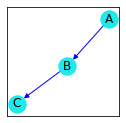

[6536]


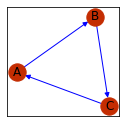

[376]


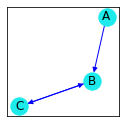

[503]


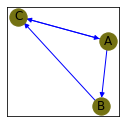

[371]


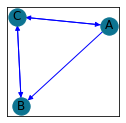

[3883]


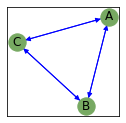

[58]


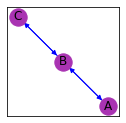

[355]


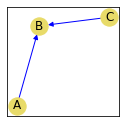

[11879]


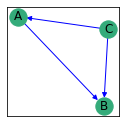

[3660]


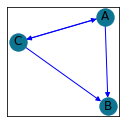

[516]


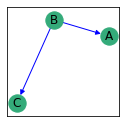

[4812]


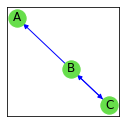

[900]


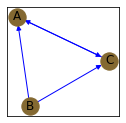

[1040]


In [149]:
sub_graphs(res)

In [57]:
def rand_freq(dens):
    e =nx.erdos_renyi_graph(64,dens,directed=True)
    freq = get_freq(e)
    for i in range(100):
        e =nx.erdos_renyi_graph(64,dens,directed=True)
        first = get_freq(e)
        for x in first.keys():
            freq[x].append(first[x][0])
    freqmean_std=freq
    for f in freq.keys():
        freqmean_std[f]=(np.mean(freq[f]),np.std(freq[f]))
    return freqmean_std

In [110]:
r_g = rand_freq(0.2)
res= get_freq(gg)

In [111]:
res

{'A->B->C': [6536],
 'A->B->C->A': [376],
 'A->B->C->B': [503],
 'A->B->C->A->C': [371],
 'A->B->C->A->C->B': [3883],
 'A->B->C->A->C->B->A': [58],
 'A->B->C->B->A': [355],
 'A->B<-C': [11879],
 'A->B<-C->A': [3660],
 'A->B<-C->A->C': [516],
 'A<-B->C': [4812],
 'A<-B->C->B': [900],
 'A<-B->C->A->C': [1040]}

In [112]:
def get_z(real, rand_g):
    result = {k: v for k, v in real.items()}
    for x in result.keys():
        div = (rand_g[x][1]+0.001)
        result[x]=(real[x][0]-rand_g[x][0])/(div)
    return result

In [113]:
get_z(res,r_g)

{'A->B->C': -3.615917133178968,
 'A->B->C->A': -4.324753579040003,
 'A->B->C->B': 8.02365496276773,
 'A->B->C->A->C': 0.9880548164117315,
 'A->B->C->A->C->B': -0.6448359764696763,
 'A->B->C->A->C->B->A': 30.929414240873403,
 'A->B->C->B->A': 3.5262557355774264,
 'A->B<-C': 23.899272656666543,
 'A->B<-C->A': 14.022634686521075,
 'A->B<-C->A->C': 9.684552685681236,
 'A<-B->C': 0.11230021961388754,
 'A<-B->C->B': -3.7798809697227354,
 'A<-B->C->A->C': 28.206565068084714}

In [114]:
r_g

{'A->B->C': (8181.415841584158, 455.04699501242317),
 'A->B->C->A': (656.8811881188119, 64.94632774604955),
 'A->B->C->B': (150.22772277227722, 43.965531320787925),
 'A->B->C->A->C': (324.41584158415844, 47.14634207259763),
 'A->B->C->A->C->B': (4381.227722772277, 772.6415648580519),
 'A->B->C->A->C->B->A': (2.6435643564356437, 1.7887666995067273),
 'A->B->C->B->A': (200.0, 43.9549724600118),
 'A->B<-C': (4781.079207920792, 296.99217188631224),
 'A->B<-C->A': (1583.4950495049504, 148.0813680368027),
 'A->B<-C->A->C': (197.05940594059405, 32.93191950705835),
 'A<-B->C': (4779.782178217822, 286.88910487201366),
 'A<-B->C->B': (1623.90099009901, 191.513229124551),
 'A<-B->C->A->C': (197.1980198019802, 29.878638948013453)}

In [115]:
final_counts = pd.DataFrame(res).T
final_counts['1']=list(get_z(res,r_g).values())
final_counts.columns = ['N_real','Z']

In [116]:
final_counts.shape

(13, 2)

In [117]:
final_counts

,N_real,Z
A->B->C,6536,-3.615917
A->B->C->A,376,-4.324754
A->B->C->B,503,8.023655
A->B->C->A->C,371,0.988055
A->B->C->A->C->B,3883,-0.644836
A->B->C->A->C->B->A,58,30.929414
A->B->C->B->A,355,3.526256
A->B<-C,11879,23.899273
A->B<-C->A,3660,14.022635
A->B<-C->A->C,516,9.684553


# 3.2
(class ‘C’) For the motif with pattern A → B ← C, create a topographical representation of the
networks considering only the connections involved in this configuration.

In [169]:
def func_3_2(graph):
    set_of_3 = set()
       
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            
            third_step = set(graph.predecessors(sec))
            #print(third_step)
            for th in third_step:
                #set_of_3.add((node,sec,th))
                if th!=node:
                    set_of_3.add((node,sec))
                    set_of_3.add((th,sec))
                
    return set_of_3

In [170]:
edges = func_3_2(gg)

In [163]:
def build_graph_3_2(edges,labels,coord):
    #idx_i, inx_j = np.where(adj==1)
    #idx_i, inx_j = list(idx_i), list(inx_j )
    #check_symmetric(adj_matr)
    our_graph=nx.DiGraph()
    for i in range(len(labels)):
        our_graph.add_node(labels[i],
                          pos=(coord[coord['label']==labels[i]]['x'].values.item(0),
                              coord[coord['label']==labels[i]]['y'].values.item(0)))
    Edges = list(edges)#[(nodes[idx_i[i]],nodes[inx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]
    
    #our_graph.add_nodes_from(labels)
    our_graph.add_edges_from(Edges)
    pos=nx.get_node_attributes(our_graph,'pos')
    #pos = nx.kamada_kawai_layout(our_graph)
    plt.figure(3,figsize=(9,9)) 
    nx.draw(our_graph,pos,with_labels=True)
    #plt.figure(3,figsize=(16,16)) 
    plt.draw()
    plt.show()
    return our_graph

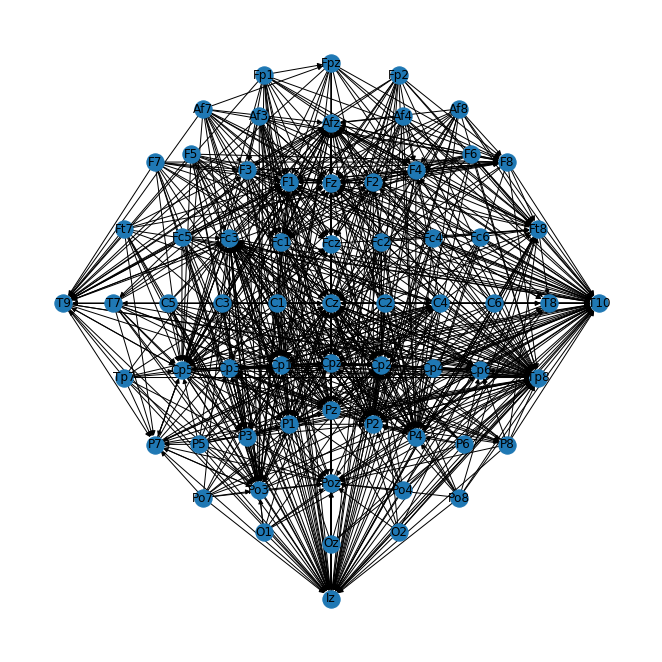

In [164]:
build_graph_3_2(edges,labels,chanel_locations)

In [171]:
len(edges)

809

In [155]:
len(gg.edges())

818

# 3.3
(class ‘C’) Choose a channel selected in parieto-occipital scalp region and determine the
motifs which involve it.

In [51]:
labels.index('Po8')

59

In [172]:
def get_freq_po(graph,po):
    #pics=[]
    configs = ['A->B->C', 'A->B->C->A','A->B<-C','A->B<-C->A','A<-B->C', 'A<-B->C->A']
    #'A->B->C' #'A->B->C->A or A->B->C->B' # 'A->B->C->A->C' # A->B->C->A->C->B->A # A->B->C->B->A
    conf1,conf2,conf22,conf222,conf_4,conf_5,conf_6 = set(),set(),set(),set(),set(),set(),set()
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            third_step = set(graph.successors(sec))
            for th in third_step:
                t = (tuple(sorted(set([node,sec,th]))))
                if (po in t) and th!=node:
                    conf1.add(t)
                if node!=th:
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == sec:
                            fifth = set(graph.successors(fourth))
                            for fi in fifth:
                                if node==fi:
                                    t=(tuple(sorted(set([node,sec,th,fourth,fi]))))
                                    if po in t:conf_6.add(t)
                        if fourth == node :
                            t = (tuple(sorted(set([node,sec,th,fourth]))))
                            if po in t: conf2.add(t)
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:

                                if fif==th:
                                    t= (tuple(sorted(set([node,sec,th,fourth,fif]))))
                                    if po in t:
                                        conf222.add(t)                            
                                    six = set(graph.successors(fif))
                                    for s in six:
                                        t=(tuple(sorted(set([node,sec,th,fourth,fif,s]))))
                                        if po in t:
                                            conf_4.add(t)
                                        if s==sec:
                                            sev = set(graph.successors(s))
                                            for se in sev:
                                                if se==node:
                                                    t= (tuple(sorted(set([node,sec,th,fourth,fif,s,se]))))
                                                    if po in t:
                                                        conf_5.add(t)
                        if fourth==sec:
                            t= (tuple(sorted(set([node,sec,th,fourth]))))
                            if po in t:
                                conf22.add(t)
    poss_confs={configs[0] : [len(conf1)]}
    poss_confs[configs[1]]=[len(conf2)]
    poss_confs['A->B->C->B']=[len(conf22)]
    poss_confs['A->B->C->A->C']=[len(conf222)]
    poss_confs['A->B->C->A->C->B']=[len(conf_4)]
    poss_confs['A->B->C->A->C->B->A']=[len(conf_5)]
    poss_confs['A->B->C->B->A']=[len(conf_6)]
    #pics.extend([conf1.pop(),conf2.pop(),conf22.pop(),conf222.pop(),conf_4.pop(),conf_5.pop()])
        #'A->B<-C' #'A->B<-C->A' or 'A->B<-C->A->C'
    conf3, conf4, conf44 = set(),set(),set()      
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            third_step = set(graph.predecessors(sec))
            #print(third_step)
            for th in third_step:
                if th!=node:
                    t = (tuple(sorted(set([node,sec,th]))))
                    if po in t:
                        conf3.add(t)    
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == node:
                            t=(tuple(sorted(set([node,sec,th,fourth]))))
                            if po in t:
                                conf4.add(t)
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif==th:
                                    t=(tuple(sorted(set([node,sec,th,fourth,fif]))))
                                    if po in t:
                                        conf44.add(t)
    poss_confs[configs[2]]=[len(conf3)]
    poss_confs[configs[3]]=[len(conf4)]
    poss_confs['A->B<-C->A->C']=[len(conf44)]
    #pics.extend([conf3.pop(),conf4.pop(),conf44.pop()])
    # 'A<-B->C'  #'A<-B->C->B->A or A<-B->C->B'  # 'A<-B->C->A->C' 
    conf5,conf6,conf7,conf8 = set(),set(),set(),set()
    for node in graph.nodes:
        second_step = set(graph.predecessors(node))
        for sec in second_step:
            third_step = set(graph.successors(sec))
            #print(third_step)
            for th in third_step:
                if th!=node:
                    t = (tuple(sorted(set([node,sec,th]))))
                    if po in t:
                        conf5.add(t)
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == node and th!=node:
                            #conf6.add((node,sec,th,fourth))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif == th:
                                    t = (tuple(sorted(set([node,sec,th,fourth,fif]))))
                                    if po in t:
                                        conf8.add(t)
                        if fourth==sec and th!=node:
                            t = (tuple(sorted(set([node,sec,th,fourth]))))
                            if po in t:
                                conf7.add(t)
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif == node:
                                    t = (tuple(sorted(set([node,sec,th,fourth,fif]))))
                                    if po in t:
                                        conf6.add(t)
    poss_confs[configs[4]]=[len(conf5)]
    #poss_confs['A<-B->C->B->A']=len(conf6)
    poss_confs['A<-B->C->B']=[len(conf7)]
    poss_confs['A<-B->C->A->C']=[len(conf8)]
    #pics.extend([conf5.pop(),conf6.pop(),conf7.pop(),conf8.pop()])
    #'A<-B->A->C->A->C''A<-B->A->C->A->C->B'
    #poss_confs['A<-B->A->C->A->C']=len(conf9)
    #poss_confs['A<-B->A->C->A->C->B']=len(conf10)
    return poss_confs#,pics

In [173]:
get_freq_po(gg,'Po8')

{'A->B->C': [87],
 'A->B->C->A': [0],
 'A->B->C->B': [43],
 'A->B->C->A->C': [0],
 'A->B->C->A->C->B': [0],
 'A->B->C->A->C->B->A': [0],
 'A->B->C->B->A': [0],
 'A->B<-C': [369],
 'A->B<-C->A': [45],
 'A->B<-C->A->C': [0],
 'A<-B->C': [55],
 'A<-B->C->B': [0],
 'A<-B->C->A->C': [11]}

In [130]:
gg.in_edges('Po8')

InEdgeDataView([])

In [132]:
set(gg.successors('Po8'))

{'Cp2', 'Cz', 'Fc3', 'Ft8', 'Fz', 'Iz', 'P4', 'Po4', 'Poz', 'T10', 'Tp8'}

In [134]:
cc=0
for s in set(gg.successors('Po8')):
    cc=cc+len(set(gg.predecessors(s)))
print(cc)

391


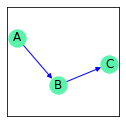

[87]


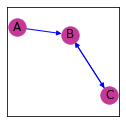

[43]


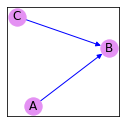

[369]


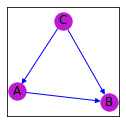

[45]


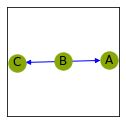

[55]


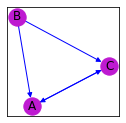

[11]


In [174]:
sub_graphs(get_freq_po(gg,'Po8'))

In [175]:
get_freq_po(gg,'Poz')

{'A->B->C': [371],
 'A->B->C->A': [14],
 'A->B->C->B': [77],
 'A->B->C->A->C': [14],
 'A->B->C->A->C->B': [312],
 'A->B->C->A->C->B->A': [0],
 'A->B->C->B->A': [6],
 'A->B<-C': [456],
 'A->B<-C->A': [163],
 'A->B<-C->A->C': [18],
 'A<-B->C': [233],
 'A<-B->C->B': [52],
 'A<-B->C->A->C': [26]}

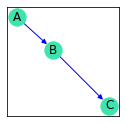

[371]


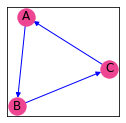

[14]


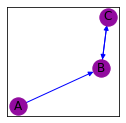

[77]


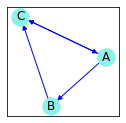

[14]


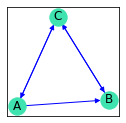

[312]


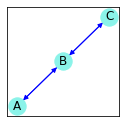

[6]


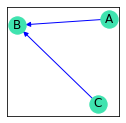

[456]


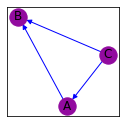

[163]


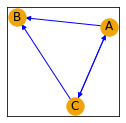

[18]


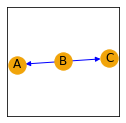

[233]


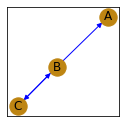

[52]


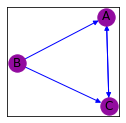

[26]


In [176]:
sub_graphs(get_freq_po(gg,'Poz'))

In [177]:
get_freq_po(gg,'Po7')

{'A->B->C': [103],
 'A->B->C->A': [0],
 'A->B->C->B': [46],
 'A->B->C->A->C': [0],
 'A->B->C->A->C->B': [0],
 'A->B->C->A->C->B->A': [0],
 'A->B->C->B->A': [0],
 'A->B<-C': [351],
 'A->B<-C->A': [46],
 'A->B<-C->A->C': [0],
 'A<-B->C': [55],
 'A<-B->C->B': [0],
 'A<-B->C->A->C': [12]}

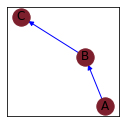

[103]


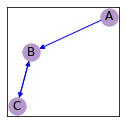

[46]


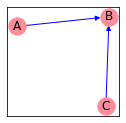

[351]


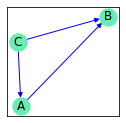

[46]


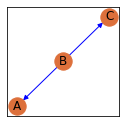

[55]


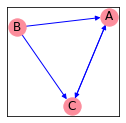

[12]


In [178]:
sub_graphs(get_freq_po(gg,'Po7'))